# Library yang digunakan

In [1]:
import pandas as pd
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import pickle

# Load Dataset

In [2]:
data = pd.read_csv("songs.csv")
data

,Name,Artist,Album,Popularity,Lyrics
0,Imagine - Remastered 2010,John Lennon,Imagine,79,8 ContributorsDiscographie 2021 — Pop & Rock L...
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,38 ContributorsA Whiter Shade of Pale Lyrics[I...
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,58 ContributorsMy Sweet Lord Lyrics[Chorus]\nM...
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,1 ContributorGod Only Knows (mono mix) LyricsI...
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,57 ContributorsBridge Over Troubled Water Lyri...
...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,192 ContributorsTranslationsTürkçeEspañolPortu...
795,Sorry,Justin Bieber,Purpose (Deluxe),83,194 ContributorsTranslationsEspañolPortuguêsFr...
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,3 ContributorsTop Tracks of 2016 - Global Lyri...
797,Take Me To Church,Hozier,The Singer Songwriter,25,339 ContributorsTranslationsفارسیEspañolFrança...


In [3]:
# Memeriksa nilai yang hilang
data.isnull().sum()

Name          0
Artist        0
Album         0
Popularity    0
Lyrics        0
dtype: int64

In [4]:
#Menghitung Rekapitulasi Popularity
data['Popularity'].value_counts()

Popularity
0     32
82    24
74    24
90    23
77    22
      ..
41     1
31     1
3      1
23     1
12     1
Name: count, Length: 84, dtype: int64

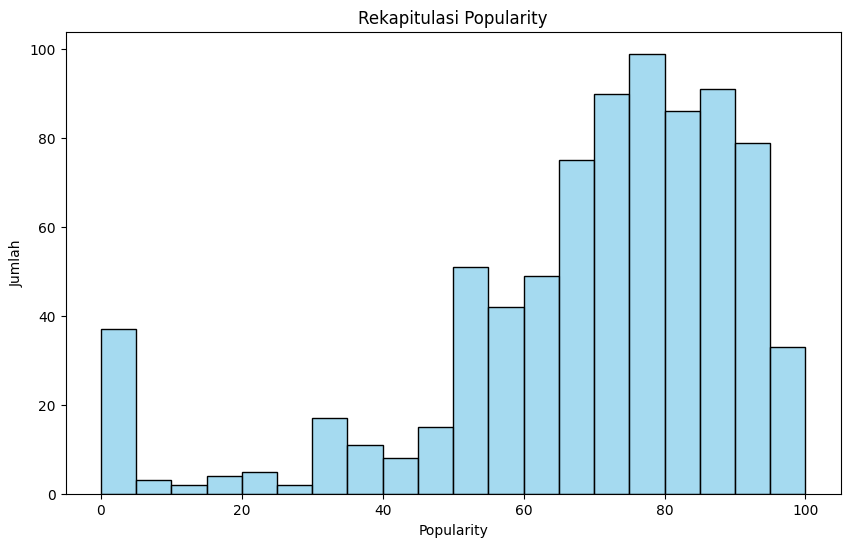

In [5]:
# Memplot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Popularity'], bins=20, kde=False, color='skyblue')
plt.title('Rekapitulasi Popularity')
plt.xlabel('Popularity')
plt.ylabel('Jumlah')
plt.show()

In [6]:
#Kolom sentimen
sentimen = []
for index, row in data.iterrows():
  if row['Popularity'] <= 33 :
    sentimen.append(-1) #less popular
  elif row['Popularity'] < 80 :
    sentimen.append(0) #quite popular
  else:
    sentimen.append(1) #very popular

data['Sentiment'] = sentimen
data

,Name,Artist,Album,Popularity,Lyrics,Sentiment
0,Imagine - Remastered 2010,John Lennon,Imagine,79,8 ContributorsDiscographie 2021 — Pop & Rock L...,0
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,38 ContributorsA Whiter Shade of Pale Lyrics[I...,-1
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,58 ContributorsMy Sweet Lord Lyrics[Chorus]\nM...,-1
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,1 ContributorGod Only Knows (mono mix) LyricsI...,0
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,57 ContributorsBridge Over Troubled Water Lyri...,0
...,...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,192 ContributorsTranslationsTürkçeEspañolPortu...,1
795,Sorry,Justin Bieber,Purpose (Deluxe),83,194 ContributorsTranslationsEspañolPortuguêsFr...,1
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,3 ContributorsTop Tracks of 2016 - Global Lyri...,-1
797,Take Me To Church,Hozier,The Singer Songwriter,25,339 ContributorsTranslationsفارسیEspañolFrança...,-1


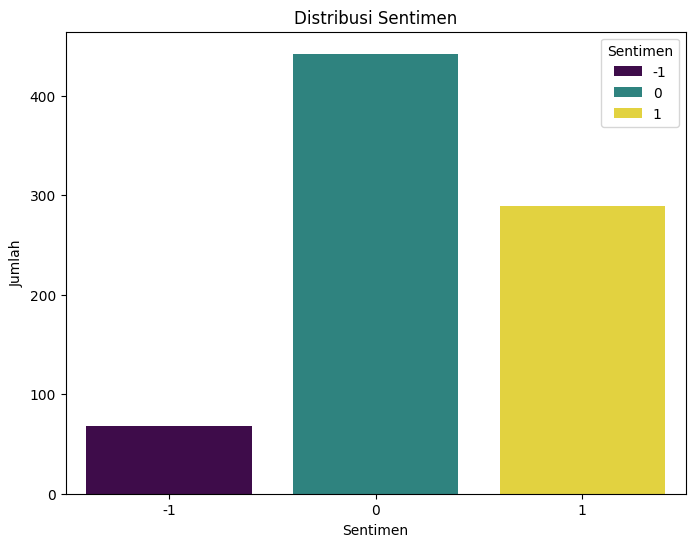

In [7]:
# Hitung jumlah data untuk setiap kategori sentimen
sentiment_counts = data['Sentiment'].value_counts()

# Plot distribusi sentimen
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index, palette="viridis", dodge=False)

# Tambahkan judul dan label sumbu
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Tampilkan plot
plt.legend(title='Sentimen')
plt.show()

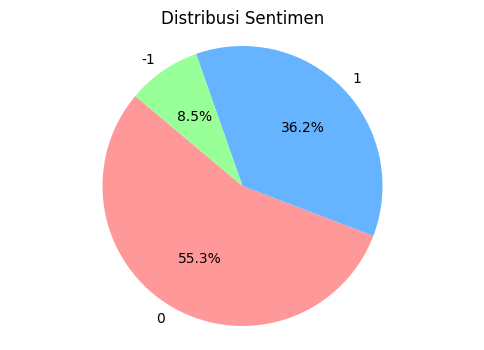

In [8]:
# Plot distribusi sentimen dalam bentuk pie chart
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

# Tambahkan judul
plt.title('Distribusi Sentimen')

# Tampilkan plot
plt.axis('equal')  # Memastikan lingkaran terlihat seperti lingkaran
plt.show()

# Text Pre-processing

In [9]:
# Fungsi untuk membersihkan teks lagu
def clean_lyrics(text):
    # Menghapus baris pertama
    text = text.split('\n', 1)[-1]
    # Menghapus string "lyrics" dan setiap karakter sebelumnya
    text = re.sub(r'.*lyrics\s*[:\[]*', '', text, flags=re.IGNORECASE)
    # Menghapus 'contributors'
    text = re.sub(r'\bcontributors\b', '', text, flags=re.IGNORECASE)
    # Menghapus angka
    text = re.sub(r'\b\d+\b', '', text)
    # Menghapus karakter khusus dan tanda baca
    text = re.sub(r'[^\w\s]', ' ', text)
    # Menghapus spasi berlebihan
    text = re.sub(r'\s+', ' ', text)
    # Mengonversi teks menjadi huruf kecil
    text = text.lower()
    return text.strip()

# Membersihkan kolom 'Lyrics'
data['Lyrics'] = data['Lyrics'].apply(clean_lyrics)

In [10]:
# Membuat objek tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Tokenisasi kolom 'Lyrics'
data['Lyrics_token'] = data['Lyrics'].apply(tokenizer.tokenize)

data

,Name,Artist,Album,Popularity,Lyrics,Sentiment,Lyrics_token
0,Imagine - Remastered 2010,John Lennon,Imagine,79,fourbi fragments ep anna pest dark arms reach ...,0,"[fourbi, fragments, ep, anna, pest, dark, arms..."
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,verse we skipped the light fandango turned car...,-1,"[verse, we, skipped, the, light, fandango, tur..."
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,my sweet lord mmm my lord mmm my lord verse i ...,-1,"[my, sweet, lord, mmm, my, lord, mmm, my, lord..."
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,but long as there are stars above you you neve...,0,"[but, long, as, there, are, stars, above, you,..."
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,when you re weary feeling small when tears are...,0,"[when, you, re, weary, feeling, small, when, t..."
...,...,...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,when your legs don t work like they used to be...,1,"[when, your, legs, don, t, work, like, they, u..."
795,Sorry,Justin Bieber,Purpose (Deluxe),83,verse you gotta go and get angry at all of my ...,1,"[verse, you, gotta, go, and, get, angry, at, a..."
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,mike posner i took a pill in ibiza seeb remix ...,-1,"[mike, posner, i, took, a, pill, in, ibiza, se..."
797,Take Me To Church,Hozier,The Singer Songwriter,25,video directed by brendan canty and conal thom...,-1,"[video, directed, by, brendan, canty, and, con..."


# Stopword Removal

In [11]:
# Download stopwords untuk bahasa Indonesia dan Inggris
nltk.download('stopwords')

# Ambil kumpulan stopwords bahasa Indonesia
stop_words_indonesian = set(stopwords.words('indonesian'))

# Ambil kumpulan stopwords bahasa Inggris
stop_words_english = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text):
    filtered_text = [word for word in text if word.lower() not in stop_words_indonesian and word.lower() not in stop_words_english]
    return filtered_text

# Terapkan fungsi pada kolom 'Lyrics_token'
data['Lyrics_token'] = data['Lyrics_token'].apply(remove_stopwords)
data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Name,Artist,Album,Popularity,Lyrics,Sentiment,Lyrics_token
0,Imagine - Remastered 2010,John Lennon,Imagine,79,fourbi fragments ep anna pest dark arms reach ...,0,"[fourbi, fragments, ep, anna, pest, dark, arms..."
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,verse we skipped the light fandango turned car...,-1,"[verse, skipped, light, fandango, turned, cart..."
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,my sweet lord mmm my lord mmm my lord verse i ...,-1,"[sweet, lord, mmm, lord, mmm, lord, verse, rea..."
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,but long as there are stars above you you neve...,0,"[long, stars, never, need, doubt, make, sure, ..."
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,when you re weary feeling small when tears are...,0,"[weary, feeling, small, tears, eyes, dry, side..."
...,...,...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,when your legs don t work like they used to be...,1,"[legs, work, like, used, sweep, feet, mouth, s..."
795,Sorry,Justin Bieber,Purpose (Deluxe),83,verse you gotta go and get angry at all of my ...,1,"[verse, gotta, go, get, angry, honesty, know, ..."
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,mike posner i took a pill in ibiza seeb remix ...,-1,"[mike, posner, took, pill, ibiza, seeb, remix,..."
797,Take Me To Church,Hozier,The Singer Songwriter,25,video directed by brendan canty and conal thom...,-1,"[video, directed, brendan, canty, conal, thoms..."


# Lemmatization

In [12]:
nltk.download('wordnet')

# Inisialisasi WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk melakukan lemmatisasi pada teks
def lemmatize_text(text):
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

# Terapkan fungsi pada kolom 'Lyrics_token' dan simpan hasilnya pada kolom 'Lemma'
data['Lemma'] = data['Lyrics_token'].apply(lemmatize_text)

data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Name,Artist,Album,Popularity,Lyrics,Sentiment,Lyrics_token,Lemma
0,Imagine - Remastered 2010,John Lennon,Imagine,79,fourbi fragments ep anna pest dark arms reach ...,0,"[fourbi, fragments, ep, anna, pest, dark, arms...","[fourbi, fragment, ep, anna, pest, dark, arm, ..."
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,verse we skipped the light fandango turned car...,-1,"[verse, skipped, light, fandango, turned, cart...","[verse, skipped, light, fandango, turned, cart..."
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,my sweet lord mmm my lord mmm my lord verse i ...,-1,"[sweet, lord, mmm, lord, mmm, lord, verse, rea...","[sweet, lord, mmm, lord, mmm, lord, verse, rea..."
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,but long as there are stars above you you neve...,0,"[long, stars, never, need, doubt, make, sure, ...","[long, star, never, need, doubt, make, sure, g..."
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,when you re weary feeling small when tears are...,0,"[weary, feeling, small, tears, eyes, dry, side...","[weary, feeling, small, tear, eye, dry, side, ..."
...,...,...,...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,when your legs don t work like they used to be...,1,"[legs, work, like, used, sweep, feet, mouth, s...","[leg, work, like, used, sweep, foot, mouth, st..."
795,Sorry,Justin Bieber,Purpose (Deluxe),83,verse you gotta go and get angry at all of my ...,1,"[verse, gotta, go, get, angry, honesty, know, ...","[verse, gotta, go, get, angry, honesty, know, ..."
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,mike posner i took a pill in ibiza seeb remix ...,-1,"[mike, posner, took, pill, ibiza, seeb, remix,...","[mike, posner, took, pill, ibiza, seeb, remix,..."
797,Take Me To Church,Hozier,The Singer Songwriter,25,video directed by brendan canty and conal thom...,-1,"[video, directed, brendan, canty, conal, thoms...","[video, directed, brendan, canty, conal, thoms..."


In [13]:
def remove_short_tokens(tokens):
    filtered_tokens = [token for token in tokens if len(token) > 3]
    return filtered_tokens

# Terapkan fungsi pada kolom 'Lemma' dan simpan hasilnya dalam kolom 'text_string'
data['Text_string'] = data['Lemma'].apply(remove_short_tokens).apply(lambda x: ' '.join(x))

data

,Name,Artist,Album,Popularity,Lyrics,Sentiment,Lyrics_token,Lemma,Text_string
0,Imagine - Remastered 2010,John Lennon,Imagine,79,fourbi fragments ep anna pest dark arms reach ...,0,"[fourbi, fragments, ep, anna, pest, dark, arms...","[fourbi, fragment, ep, anna, pest, dark, arm, ...",fourbi fragment anna pest dark reach skyward b...
1,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade Of Pale,0,verse we skipped the light fandango turned car...,-1,"[verse, skipped, light, fandango, turned, cart...","[verse, skipped, light, fandango, turned, cart...",verse skipped light fandango turned cartwheel ...
2,My Sweet Lord,George Harrison,All Things Must Pass (Remastered),0,my sweet lord mmm my lord mmm my lord verse i ...,-1,"[sweet, lord, mmm, lord, mmm, lord, verse, rea...","[sweet, lord, mmm, lord, mmm, lord, verse, rea...",sweet lord lord lord verse really wanna really...
3,God Only Knows - Mono,The Beach Boys,Pet Sounds (Original Mono & Stereo Mix),67,but long as there are stars above you you neve...,0,"[long, stars, never, need, doubt, make, sure, ...","[long, star, never, need, doubt, make, sure, g...",long star never need doubt make sure know with...
4,Bridge Over Troubled Water,Simon & Garfunkel,Bridge Over Troubled Water,72,when you re weary feeling small when tears are...,0,"[weary, feeling, small, tears, eyes, dry, side...","[weary, feeling, small, tear, eye, dry, side, ...",weary feeling small tear side time rough frien...
...,...,...,...,...,...,...,...,...,...
794,Thinking out Loud,Ed Sheeran,x (Deluxe Edition),85,when your legs don t work like they used to be...,1,"[legs, work, like, used, sweep, feet, mouth, s...","[leg, work, like, used, sweep, foot, mouth, st...",work like used sweep foot mouth still remember...
795,Sorry,Justin Bieber,Purpose (Deluxe),83,verse you gotta go and get angry at all of my ...,1,"[verse, gotta, go, get, angry, honesty, know, ...","[verse, gotta, go, get, angry, honesty, know, ...",verse gotta angry honesty know well apology ho...
796,Lean On (feat. MØ & DJ Snake),Major Lazer,Major Lazer Essentials,30,mike posner i took a pill in ibiza seeb remix ...,-1,"[mike, posner, took, pill, ibiza, seeb, remix,...","[mike, posner, took, pill, ibiza, seeb, remix,...",mike posner took pill ibiza seeb remix chainsm...
797,Take Me To Church,Hozier,The Singer Songwriter,25,video directed by brendan canty and conal thom...,-1,"[video, directed, brendan, canty, conal, thoms...","[video, directed, brendan, canty, conal, thoms...",video directed brendan canty conal thomson ver...


In [14]:
data.dtypes

Name            object
Artist          object
Album           object
Popularity       int64
Lyrics          object
Sentiment        int64
Lyrics_token    object
Lemma           object
Text_string     object
dtype: object

In [15]:
# Mengonversi kolom 'Text_string' menjadi tipe data string
data['Text_string'] = data['Text_string'].astype('str')
data['Text_string'] = data['Text_string'].astype(pd.StringDtype())
data.dtypes

Name                    object
Artist                  object
Album                   object
Popularity               int64
Lyrics                  object
Sentiment                int64
Lyrics_token            object
Lemma                   object
Text_string     string[python]
dtype: object

WordCloud

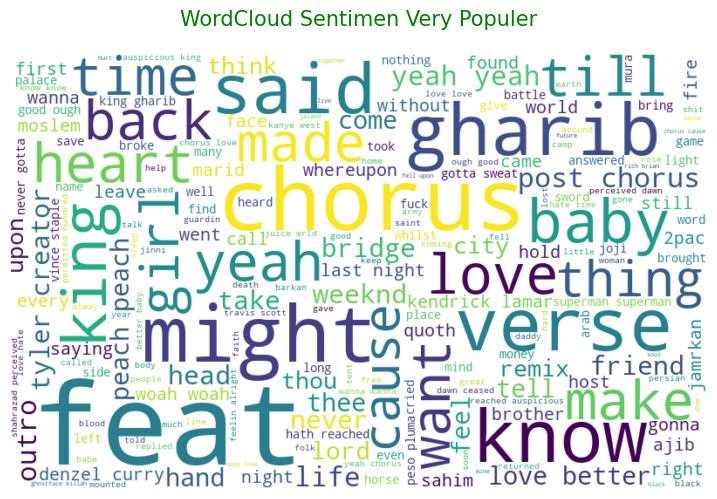

In [16]:
# Filter DataFrame untuk sentimen very populer
data_popular = data[data['Sentiment'] == 1]

# Gabungkan semua teks dalam kolom 'Text_string' untuk sentimen very popular
all_words_popular = ' '.join(data_popular['Text_string'])

# Buat WordCloud untuk sentimen very popular
wordcloud_popular = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='viridis').generate(all_words_popular)

# Tampilkan WordCloud
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud_popular, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Very Populer', fontsize=15, pad=20, color='green')
plt.show()

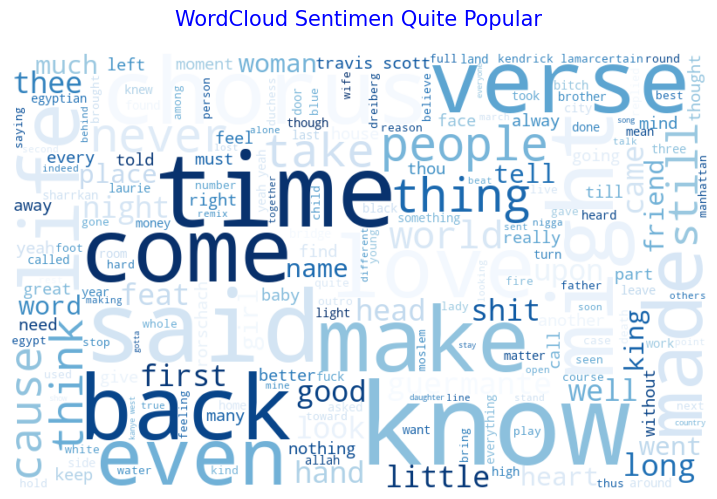

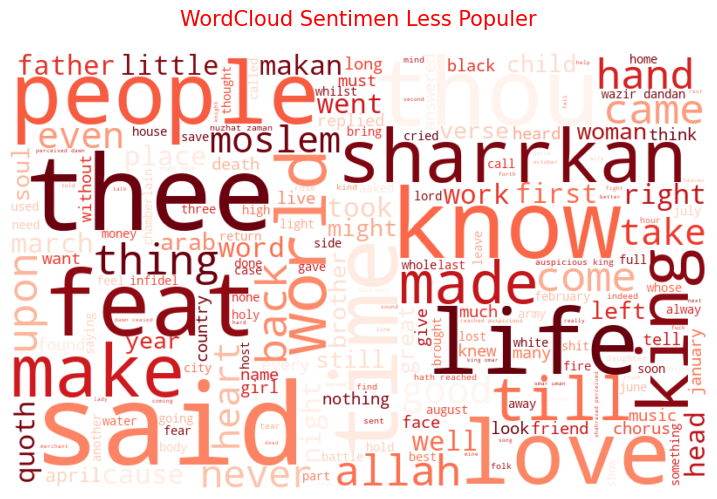

In [17]:
# Filter DataFrame untuk sentimen quite popular
data_moderate = data[data['Sentiment'] == 0]

# Filter DataFrame untuk sentimen less populer
data_not_popular = data[data['Sentiment'] == -1]

# Gabungkan semua teks dalam kolom 'text_string' untuk sentimen quite popular
all_words_moderate = ' '.join(data_moderate['Text_string'])

# Gabungkan semua teks dalam kolom 'text_string' untuk sentimen less populer
all_words_not_popular = ' '.join(data_not_popular['Text_string'])

# Buat WordCloud untuk sentimen sedang dengan warna biru
wordcloud_moderate = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='Blues').generate(all_words_moderate)

# Buat WordCloud untuk sentimen less populer dengan warna merah
wordcloud_not_popular = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='Reds').generate(all_words_not_popular)

# Tampilkan WordCloud untuk sentimen quite popular
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud_moderate, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Quite Popular', fontsize=15, pad=20, color='blue')
plt.show()

# Tampilkan WordCloud untuk sentimen less populer
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud_not_popular, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Less Populer', fontsize=15, pad=20, color='red')
plt.show()

TF-IDF

In [18]:
X = data['Text_string']
y = data['Sentiment']
tfidf_vectorizer = TfidfVectorizer()
X_final =  tfidf_vectorizer.fit_transform(X)
print(X_final)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 157519 stored elements and shape (799, 35114)>
  Coords	Values
  (0, 12359)	0.028744259122856292
  (0, 12382)	0.0352343717060825
  (0, 1576)	0.011172252833739817
  (0, 23302)	0.013257393352283082
  (0, 7936)	0.007179873490003536
  (0, 25294)	0.008665700176495325
  (0, 28488)	0.013744342684725182
  (0, 3991)	0.00841459306184534
  (0, 33954)	0.006634444482973068
  (0, 11836)	0.008613113908212854
  (0, 12726)	0.028744259122856292
  (0, 25800)	0.014372129561428146
  (0, 11858)	0.014372129561428146
  (0, 21103)	0.014372129561428146
  (0, 18111)	0.014372129561428146
  (0, 31935)	0.014372129561428146
  (0, 19634)	0.014372129561428146
  (0, 13475)	0.010859974661808214
  (0, 34075)	0.01153680235591673
  (0, 14680)	0.007626780881852945
  (0, 1950)	0.04311638868428444
  (0, 16760)	0.14372129561428146
  (0, 19403)	0.14372129561428146
  (0, 24860)	0.028744259122856292
  (0, 12542)	0.014372129561428146
  :	:
  (798, 33538)	0.1462475226272

In [19]:
pickle.dump(tfidf_vectorizer, open("tf_idf_vectorizer.pkl", "wb"))

Handling Imbalance Data

In [20]:
# Handling imbalanced using SMOTE
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(X_final, y)

In [21]:
# Hitung jumlah sampel untuk setiap kelas
jumlah_kelas = y_sm.value_counts()

# Cetak jumlah sampel untuk setiap kelas
print("Jumlah sampel untuk setiap kelas:")
print(jumlah_kelas)

Jumlah sampel untuk setiap kelas:
Sentiment
 0    442
-1    442
 1    442
Name: count, dtype: int64


Split Data

In [22]:
# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=42)

Modelling

In [23]:
# Inisialisasi model SVM
svm_model = SVC()

# Latih model SVM menggunakan data latih
svm_model.fit(X_train, y_train)

# Prediksi kelas menggunakan data uji
y_pred = svm_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Cetak hasil evaluasi
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.8984962406015038
Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.99      0.96        90
           0       0.81      0.93      0.86        85
           1       0.97      0.78      0.87        91

    accuracy                           0.90       266
   macro avg       0.91      0.90      0.90       266
weighted avg       0.91      0.90      0.90       266



Confusion Matrix

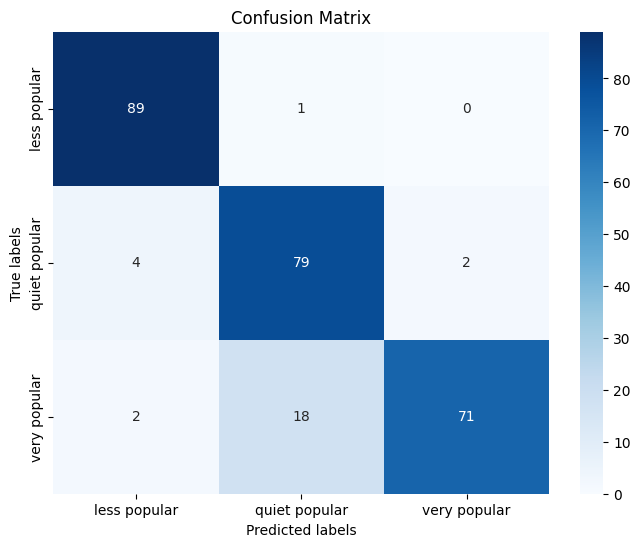

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['less popular', 'quiet popular', 'very popular']

# Membuat heatmap untuk visualisasi confusion matrix dengan label yang sesuai
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Pengujian Manual

In [25]:
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words_indonesian and word.lower() not in stop_words_english]
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return ' '.join([token for token in lemmatized_text if len(token) > 3])

# Fungsi untuk memprediksi popularitas dari input lirik lagu
def predict_popularity(lyrics):
    # Preprocessing input lirik
    cleaned_lyrics = clean_lyrics(lyrics)
    processed_lyrics = preprocess_text(cleaned_lyrics)

    # Konversi lirik yang sudah di-preprocess ke fitur TF-IDF
    input_vector = tfidf_vectorizer.transform([processed_lyrics])

    # Prediksi sentimen popularitas
    prediction = svm_model.predict(input_vector)[0]

    # Interpretasi hasil prediksi
    if prediction == 1:
        return "Very Popular"
    elif prediction == 0:
        return "Quite Popular"
    else:
        return "Less Popular"


In [26]:
# Fungsi utama untuk menerima input lirik secara manual
def main():
    print("Selamat datang di prediktor popularitas lirik lagu!")
    print("Silakan masukkan lirik lagu di bawah ini (ketik 'EXIT' untuk keluar):\n")

    while True:
        new_lyrics = input("Masukkan lirik lagu: ")
        if new_lyrics.strip().upper() == "EXIT":
            print("Terima kasih! Program telah selesai.")
            break
        predicted_popularity = predict_popularity(new_lyrics)
        print(f"Prediksi popularitas lirik: {predicted_popularity}\n")

# Menjalankan fungsi utama
main()

Selamat datang di prediktor popularitas lirik lagu!
Silakan masukkan lirik lagu di bawah ini (ketik 'EXIT' untuk keluar):

Prediksi popularitas lirik: Quite Popular

Terima kasih! Program telah selesai.


# Simpan Model

In [27]:
filename = 'prediksi_lirik.pkl'
pickle.dump(svm_model, open(filename, 'wb'))